# Integrals with Cos

In [7]:
(* https://mathematica.stackexchange.com/questions/850/how-do-i-clear-all-user-defined-symbols/861#861 *)
<< Utilities`CleanSlate`
CleanSlate[];

ClearAll["Global`*"]
(* ClearSystemCache[] *)
(* https://mathematica.stackexchange.com/questions/111605/quit-vs-clearallglobal *)
if[Length[Names["Global`*"]] > 0, Remove["Global`*"]];

  (CleanSlate) Contexts purged: {Global`}
  (CleanSlate) Approximate kernel memory recovered: 7 Kb


# Интегрирование по частям
[Integrate By Parts](https://resources.wolframcloud.com/FunctionRepository/resources/IntegrateByParts/)
Contributed by: Wolfram|Alpha Math Team

In [8]:
IntegrateByParts // ClearAll;
IntegrateByParts[ args___ ] :=
    Module[ { res },
        update[ ];
        res = Symbol[ "ResourceFunctionHelpers`IntegrateByParts" ][ args ];
        res /; Head @ res =!= Symbol[ "ResourceFunctionHelpers`IntegrateByParts" ]
    ];

In [10]:
update // ClearAll;
update[ ] /; $VersionNumber <= 12 :=
    Once[

        If[ MemberQ[ PacletSites[ ], $publicPacletSite ],
            PacletManager`PacletUpdate[
                "ResourceFunctionHelpers",
                "Site"        -> "http://pacletserver.wolfram.com",
                "UpdateSites" -> True
            ]
        ];

        Quiet @ Block[ { $ContextPath }, Get[ "ResourceFunctionHelpers`" ] ]
    ];

In [12]:
update // ClearAll;
update[ ] /; $VersionNumber <= 12 :=
    Once[

        If[ MemberQ[ PacletSites[ ], $publicPacletSite ],
            PacletManager`PacletUpdate[
                "ResourceFunctionHelpers",
                "Site"        -> "http://pacletserver.wolfram.com",
                "UpdateSites" -> True
            ]
        ];

        Quiet @ Block[ { $ContextPath }, Get[ "ResourceFunctionHelpers`" ] ]
    ];

$$
  I_4(u) = \int_{r_1}^\infty \frac{24r^2u^6 + 48u^6r + 120r^{3/2}u^4 - 96u^6 + 96u^4\sqrt{r} - u^2r^2 + 133u^2r - 2r^{3/2}}{r^4\sqrt{u^2r + 2\sqrt{r} - u^2}} \, dr,
$$
где при $r \ge r_1$ выражение $u^2r + 2\sqrt{r} - u^2 \ge 0$.

Всюду предполагается $u \gt 0$.

## Интегрант $f_4(u, r)$:

$$
  f_4(u, r) = \frac{24r^2u^6 + 48u^6r + 120r^{3/2}u^4 - 96u^6 + 96u^4\sqrt{r} - u^2r^2 + 133u^2r - 2r^{3/2}}{r^4\sqrt{u^2r + 2\sqrt{r} - u^2}}
$$

In [14]:
integrand4[u_, r_] = (24*r^2*u^6 + 48*u^6*r + 120*r^(3/2)*u^4 - 96*u^6 + 96*u^4*Sqrt[r] - u^2*r^2 + 133*u^2*r - 2*r^(3/2)) /
  (r^4*Sqrt[u^2*r + 2*Sqrt[r] - u^2]);

Значение интегранта при любом $u$ на бесконечно больших $r$ равно 0:

In [15]:
Limit[integrand4[u, r], r -> Infinity]

0

### Выражение для левой границы $r_1$

4               4
2 + u  - 2 Sqrt[1 + u ]
-----------------------
           4
          u
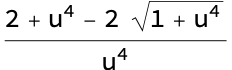

In [18]:
eqr1[u_, r_] = u^2*r + 2*Sqrt[r] - u^2;
sol = Assuming[{u ∈ Reals, r ∈ Reals, r > 0}, Solve[eqr1[u, r] == 0, r]];
r1[u_] = Simplify[r/.sol[[1]]]

$r_1$ обращается в 0 при $u \rightarrow 0$:

4
u        6
-- + O[u]
4
0
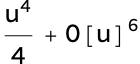

In [19]:
Series[r1[u], {u, 0, 5}]
Limit[r1[u], u -> 0]

И проверим, что знаменатель обращается в 0 при $r = r_1$

-Graphics-
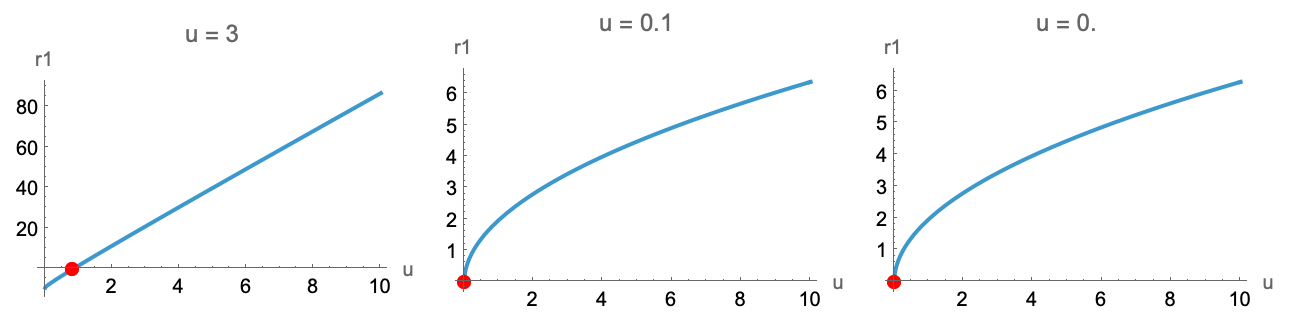

In [23]:
PlotR1[u_] := Module[
  {points, r1Value},

  r1Value = Piecewise[{{0, u == 0}}, r1[u]];
  points = {{r1Value, eqr1[u, r1Value]}};

  plotLabel = "u = " <> ToString[u];

  Show[
    Plot[
      eqr1[u, r],
      {r, -1, 10},
      AxesLabel -> {"u", "r1"},
      PlotLabel -> plotLabel,
      PlotRange -> All
    ],
    ListPlot[
      points,
      PlotStyle -> {Red, PointSize[Large]}
    ]
  ]
]

plots = {PlotR1[3], PlotR1[0.1], PlotR1[0.0]};
GraphicsRow[plots]

### Графики функций интегранта $f_4(u_i, r)$:

-Graphics-
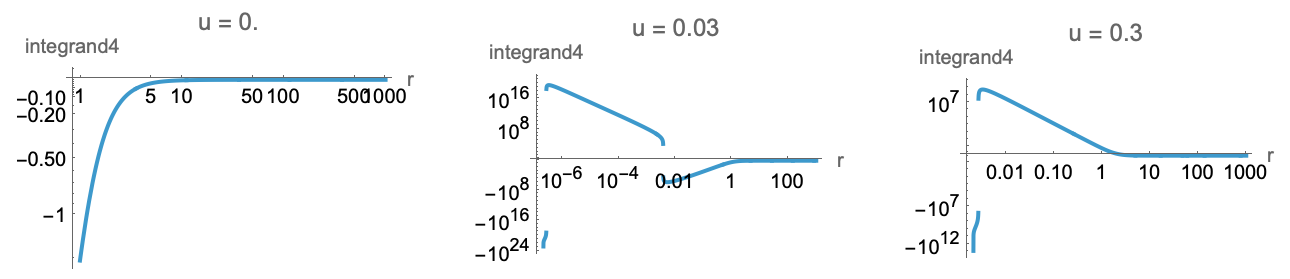

In [26]:
PlotIntegrand4[u_] := Module[
  {r1Value},

  r1Value = Piecewise[{{0, u == 0}}, r1[u]];

  plotLabel = "u = " <> ToString[u];

  Plot[
    integrand4[u, r],
    {r, r1Value, 10^3},
    PlotLabel -> plotLabel,
    PlotRange -> All,
    AxesOrigin -> {0, 0},
    AxesLabel -> {"r", "integrand4"},
    ScalingFunctions -> {"Log", "SignedLog"}
  ]
]

plots = {PlotIntegrand4[0.0], PlotIntegrand4[0.03], PlotIntegrand4[0.3]};
GraphicsRow[plots]

*Mathematica* очень долго берёт этот интеграл, но выдаёт огромную простыню выражений, которую не может упростить, используя при это коплексную экспоненту.

Inactive[Integrate][Inactive[integrand4][u, r], {r, Inactive[r1][u], Infinity}, 
 
>   Assumptions -> {Inactive[Element][u, Reals], Inactive[Greater][u, 0]}]
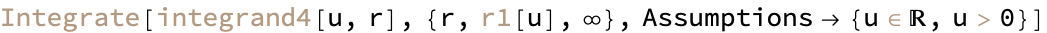

In [27]:
Inactivate[Integrate[integrand4[u, r], {r, r1[u], Infinity}, Assumptions -> {u ∈ Reals, u > 0}]]

## Численный график $I_4(u)$ с использованием NIntegrate:

-Graphics-
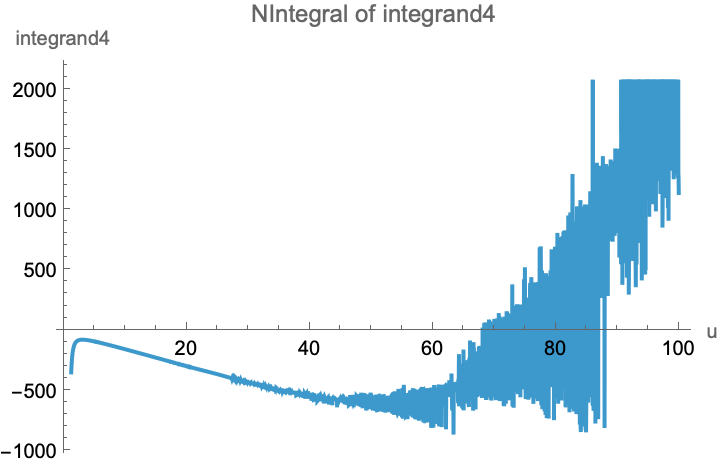

In [28]:
Plot[
  NIntegrate[integrand4[u, r], {r, r1[u], Infinity}],
  {u, 1, 100},
  PlotLabel -> "NIntegral of integrand4",
  AxesLabel -> {"u", "integrand4"}
]

## Численный график $I_4(u)$ с использованием Integrate:

-Graphics-
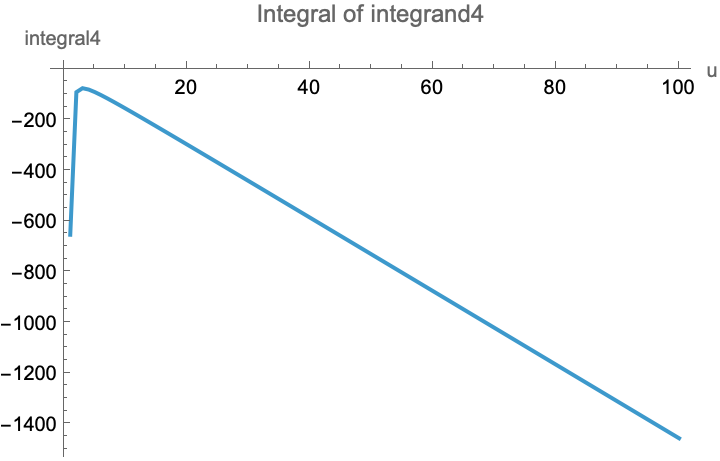

In [31]:
(* points = With[
  {u := 10^up},
  Table[
    {u, N[Integrate[integrand4[u, r], {r, r1[u], Infinity}]]},
    {up, 0, 2, 0.05}
  ]
]; *)

points = Table[
  {u, N[Integrate[integrand4[u, r], {r, r1[u], Infinity}]]},
  {u, 1, 100, 1}
];

ListPlot[
  points,
  Joined -> True,
  PlotRange -> All,
  PlotLabel -> "Integral of integrand4",
  AxesLabel -> {"u", "integral4"}
]

## Первообразная $\tilde{I}_4(u, r)$:

2      2        3/2  4                8        10
(-((u Sqrt[2 Sqrt[r] - u  + r u ] (170 r    u  + 384 Sqrt[r] u  + 384 u   + 
 
                  6           4     2  2             4     5/2              4       3
>            6 r u  (11 + 32 u ) + r  u  (425 + 111 u ) + r    (1275 + 673 u ))) / r ) + 
 
                        4       8
>     (3 I) (425 + 366 u  + 37 u ) Log[
 
                5              2                         2      2
         (8 I) u  (-Sqrt[r] + u  + I u Sqrt[2 Sqrt[r] - u  + r u ])          7
>        ----------------------------------------------------------]) / (12 u )
                                           4       8
                       Sqrt[r] (425 + 366 u  + 37 u )
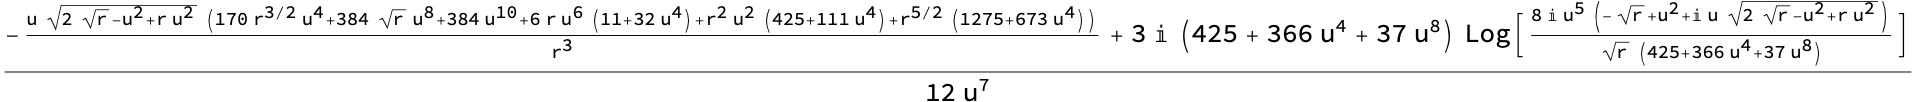

In [32]:
antiderivative4[u_, r_] = Integrate[integrand4[u, r], r]

Явно определим аргумент комплексного числа:

In [33]:
(* complexLog[z_] := Log[Abs[z]] + I Arg[z]; *)
arg[z_] := ArcTan[ComplexExpand[Im[z]]/ComplexExpand[Re[z]]];
(* abs[z_] := ComplexExpand[Abs[z]]; *)

Применяя его к antiderivative4[u, r], мы получаем действительное выражение, состоящее из двух слагаемых одно без $\tan^{-1}$, а второе, включающее $\tan^{-1}$:

3/2
  1                      2      2    2        425    170 r                   2
-(--) (Sqrt[2 Sqrt[r] - u  + r u ] (r  (111 + ---) + -------- + 384 Sqrt[r] u  + 
  12                                           4         2
                                              u         u
 
                                       5/2              4
               4                 4    r    (1275 + 673 u )      3
>         384 u  + 6 r (11 + 32 u ) + --------------------)) / r  - 
                                                6
                                               u
 
                                                     2
                4       8                 Sqrt[r] - u
    (425 + 366 u  + 37 u ) ArcTan[-----------------------------]
                                                      2      2
                                  u Sqrt[2 Sqrt[r] - u  + r u ]
>   ------------------------------------------------------------
                                   7
                                4 u
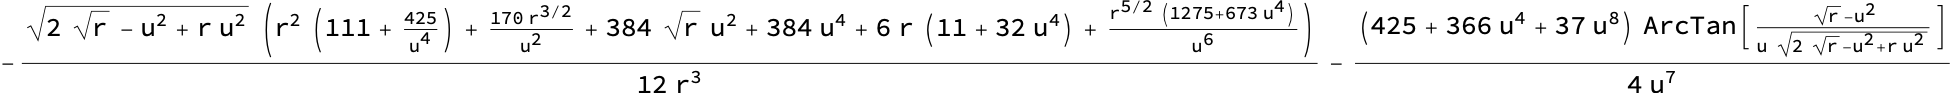

In [37]:
antiderivative4s[u_, r_] =
  Simplify[
    ComplexExpand[
      Re[antiderivative4[u, r]]
    ] /. Arg -> arg,
    {{u, r} ∈ Reals, u > 0, r > r1[u]}
  ];

antiderivative4s[u_, r_] =
  Sqrt[2 Sqrt[r] - u^2 + r u^2] * Simplify[
    Expand[
      (antiderivative4s[u, r] /. ArcTan[x_] -> 0) /
      Sqrt[2 Sqrt[r] - u^2 + r u^2]
    ],
    {{u, r} ∈ Reals, u > 0, r > 0}
  ] -
  Cases[antiderivative4s[u, r],
    coeff_.*ArcTan[arg_] :> coeff*ArcTan[arg], ∞][[2]] /
  (12 * r^3 * u^7)

### График первообразной $\tilde{I}_4(u_i, r)$:

-Graphics-
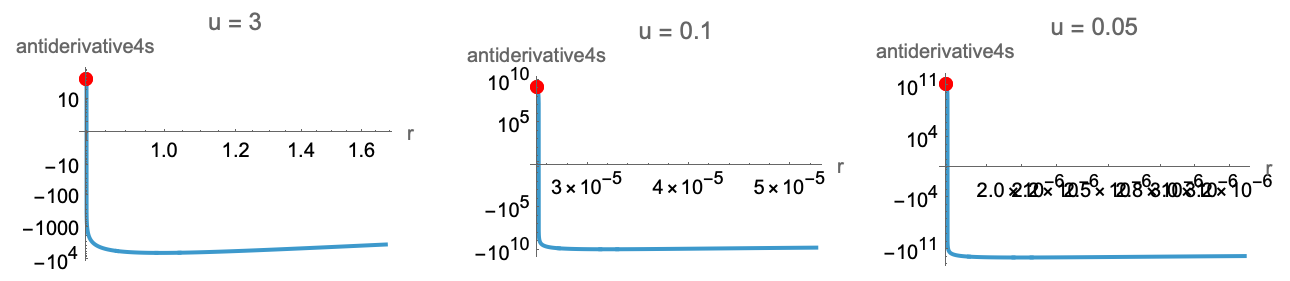

In [41]:
rules = {
  eqr1[u, r] -> 0,
  ArcTan[x_] -> -Pi/2
};

PlotAntiderivative[u_] := Module[
  {points, antiderivative, r1Value},

  r1Value = r1[u]*(1.0+10^-12);
  antiderivative =
    If[r == r1Value,
      antiderivative4s[u, r] /. rules,
      antiderivative4s[u, r]
    ];

  points = {{r1Value, Re[antiderivative /. r -> r1Value]}};

  plotLabel = "u = " <> ToString[u];

  Show[
    Plot[
      antiderivative,
      {r, r1Value, r1Value*2.1},
      PlotLabel -> plotLabel,
      PlotRange -> All,
      AxesLabel -> {"r", "antiderivative4s"},
      ScalingFunctions -> {"SignedLog", "SignedLog"}
    ],
    ListPlot[
      points,
      PlotRange -> All,
      PlotStyle -> {Red, PointSize[Large]},
      ScalingFunctions -> {"SignedLog", "SignedLog"}
    ]
  ]
]

plots = {PlotAntiderivative[3], PlotAntiderivative[0.1], PlotAntiderivative[5*10.0^-2]};
GraphicsRow[plots]

## Определённый интеграл, возьмём как разницу первообразных по теореме Ньютона-Лейбница,
$$
  I_{4,1}(u) = \int_{r_1}^{\infty} f_4(u, r) \, dr = \tilde{I}_{4}(u, \infty) - \tilde{I}_{4}(u, r_1(u)):
$$

Найдём $\tilde{I}_{4}(u, \infty)$:

2              4                  4       8          -2
  1   u  (1275 + 673 u ) + 3 (425 + 366 u  + 37 u ) ArcTan[u  ]
-(--) ---------------------------------------------------------
  12                              7
                                 u
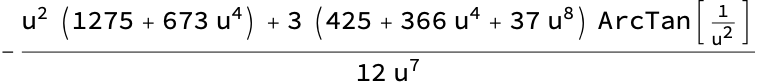

In [43]:
integral4Inf[u_] = Limit[
  antiderivative4s[u, r],
  r -> Infinity,
  Assumptions -> {u ∈ Reals, u > 0}
];

integral4Infs[u_] = Simplify[
  ComplexExpand[
    Re[integral4Inf[u]]
  ] /. Arg -> arg,
  {{u, r} ∈ Reals, u > 0, r > r1[u]}
]

Найдём $\tilde{I}_{4}(r_1(u))$, при этом заметим, что $2\sqrt{r} - u^2 + r u^2 = 0$, и $\mathrm{arctan}(-\infty) = -\frac{\pi}{2}$:

4       8
Pi (425 + 366 u  + 37 u )
-------------------------
             7
          8 u
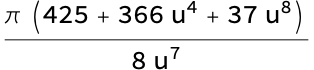

In [44]:
integral4r1[u_] = antiderivative4s[u, r] /. rules

### Графики функций $\tilde{I}_{4}(u, r_i)$:

Legended[-Graphics-, Placed[LineLegend[{Directive[Opacity[1.], RGBColor[0.24, 0.6, 0.8], 
 
>       AbsoluteThickness[2]], Directive[Opacity[1.], RGBColor[0.95, 0.627, 0.1425], 
 
>       AbsoluteThickness[2]], Directive[Opacity[1.], RGBColor[0.455, 0.7, 0.21], 
 
>       AbsoluteThickness[2]], Directive[Opacity[1.], 
 
>       RGBColor[0.922526, 0.385626, 0.209179], AbsoluteThickness[2]], 
 
>      Directive[Opacity[1.], RGBColor[0.578, 0.51, 0.85], AbsoluteThickness[2]]}, 
 
>     {antiderivative4s[r=1], antiderivative4s[r=10^2], antiderivative4s[r=10^5], 
 
>      antiderivative4s[r=10^10], antiderivative4s[r=Infinity]}, LegendMarkers -> None, 
 
>     LabelStyle -> {}, LegendLayout -> Column], After, Identity]]
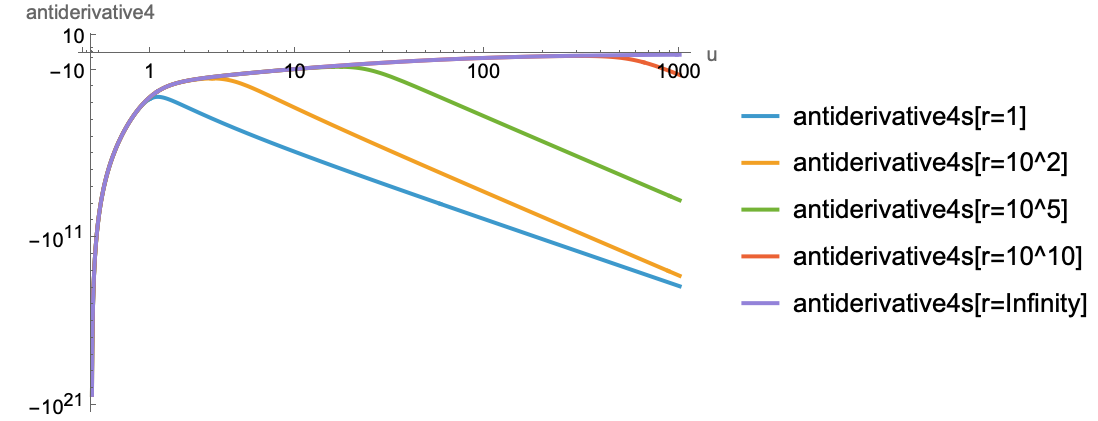

In [45]:
Plot[
  {
    N[antiderivative4s[u, 1]],
    N[antiderivative4s[u, 10^2]],
    N[antiderivative4s[u, 10^5]],
    N[antiderivative4s[u, 10^10]],
    N[integral4Infs[u]]
  },
  {u, 0, 1000},
  AxesLabel -> {"u", "antiderivative4"},
  PlotLegends -> {
    "antiderivative4s[r=1]",
    "antiderivative4s[r=10^2]",
    "antiderivative4s[r=10^5]",
    "antiderivative4s[r=10^10]",
    "antiderivative4s[r=Infinity]"
  },
  ScalingFunctions -> {"SignedLog", "SignedLog"}
]

Legended[-Graphics-, Placed[LineLegend[{Directive[Opacity[1.], RGBColor[0.24, 0.6, 0.8], 
 
>       AbsoluteThickness[2]], Directive[Opacity[1.], RGBColor[0.95, 0.627, 0.1425], 
 
>       AbsoluteThickness[2]], Directive[Opacity[1.], RGBColor[0.455, 0.7, 0.21], 
 
>       AbsoluteThickness[2]], Directive[Opacity[1.], 
 
>       RGBColor[0.922526, 0.385626, 0.209179], AbsoluteThickness[2]], 
 
>      Directive[Opacity[1.], RGBColor[0.578, 0.51, 0.85], AbsoluteThickness[2]], 
 
>      Directive[Opacity[1.], RGBColor[0.772079, 0.431554, 0.102387], 
 
>       AbsoluteThickness[2]], Directive[Opacity[1.], RGBColor[0.4, 0.64, 1.], 
 
>       AbsoluteThickness[2]], Directive[Opacity[1.], RGBColor[1., 0.75, 0.], 
 
>       AbsoluteThickness[2]]}, {antiderivative4s[r=r1[u]+10^{-2}], 
 
>      antiderivative4s[r=r1[u]+10^{-4}], antiderivative4s[r=r1[u]+10^{-5}], 
 
>      antiderivative4s[r=r1[u]+1.35*10^-6], antiderivative4s[r=r1[u]+10^{-7}], 
 
>      antiderivative4s[r=r1[u]+10^{-10}], antiderivative4s[r=r1[u]+10^{-12}], 
 
>      antiderivative4s[r=r1[u]]}, LegendMarkers -> None, LabelStyle -> {}, 
 
>     LegendLayout -> Column], After, Identity]]
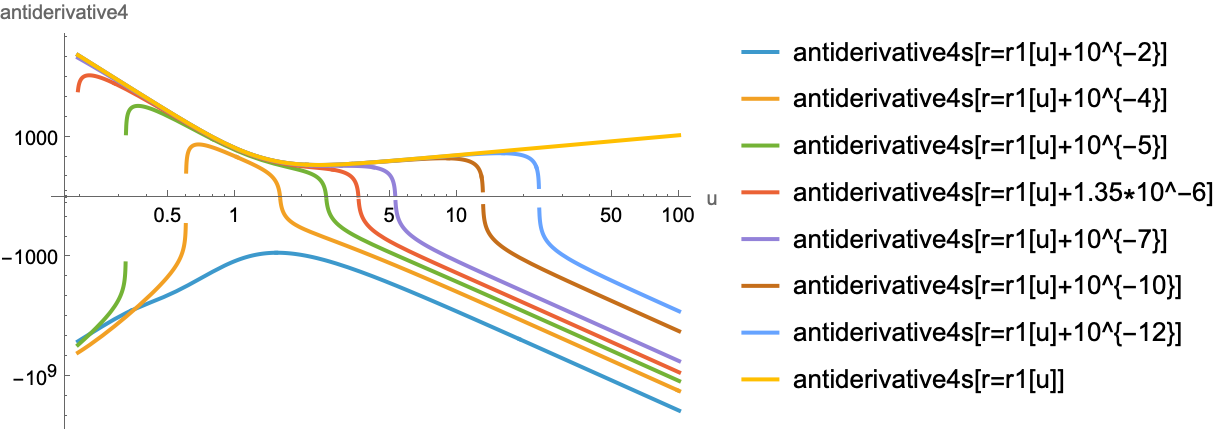

In [46]:
Plot[
  {
    N[Re[antiderivative4s[u, r1[u]+10^-2]]],
    N[Re[antiderivative4s[u, r1[u]+10^-4]]],
    N[Re[antiderivative4s[u, r1[u]+10^-5]]],
    N[Re[antiderivative4s[u, r1[u]+1.35*10^-6]]],
    N[Re[antiderivative4s[u, r1[u]+10^-7]]],
    N[Re[antiderivative4s[u, r1[u]+10^-10]]],
    N[Re[antiderivative4s[u, r1[u]+10^-12]]],
    N[integral4r1[u]]
  },
  {u, 0.0, 100},
  AxesLabel -> {"u", "antiderivative4"},
  PlotLegends -> {
    "antiderivative4s[r=r1[u]+10^{-2}]",
    "antiderivative4s[r=r1[u]+10^{-4}]",
    "antiderivative4s[r=r1[u]+10^{-5}]",
    "antiderivative4s[r=r1[u]+1.35*10^-6]",
    "antiderivative4s[r=r1[u]+10^{-7}]",
    "antiderivative4s[r=r1[u]+10^{-10}]",
    "antiderivative4s[r=r1[u]+10^{-12}]",
    "antiderivative4s[r=r1[u]]"
    },
  PlotRange -> All,
  ScalingFunctions -> {"Log", "SignedLog"}
]

## Итоговый ответ для $I_4(u)$:

2              4                  4       8                  -2
  1   2 u  (1275 + 673 u ) + 3 (425 + 366 u  + 37 u ) (Pi + 2 ArcTan[u  ])
-(--) --------------------------------------------------------------------
  24                                    7
                                       u
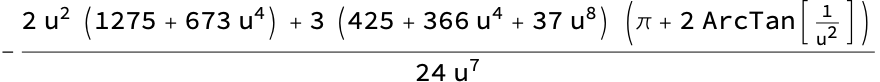

In [47]:
I4[u_] = Simplify[Collect[Simplify[integral4Infs[u] - integral4r1[u], {u ∈ Reals, u > 0}], (425 + 366*u^4 + 37*u^8)]]

In [48]:
TeXForm[I4[u]]

-\frac{2 \left(673 u^4+1275\right) u^2+3 \left(37 u^8+366 u^4+425\right) \left(2 \tan\
 
>   ^{-1}\left(\frac{1}{u^2}\right)+\pi \right)}{24 u^7}

## Сравнение Integrate и аналитической $I_4(u)$

Legended[Legended[-Graphics-, Placed[LineLegend[{Directive[Opacity[1.], 
 
>        RGBColor[0.24, 0.6, 0.8], AbsoluteThickness[2]]}, {I [u]}, 
                                                             4
 
>      LegendMarkers -> None, LabelStyle -> {}, LegendLayout -> Column], After, Identity]
 
>     ], Placed[PointLegend[{Directive[PointSize[0.00916667], AbsoluteThickness[2], 
 
>       RGBColor[1, 0, 0], Dashing[{Small, Small}]]}, {Integrate I [u]}, 
                                                                  4
 
>     LegendMarkers -> {{False, Automatic}}, Joined -> {False}, LabelStyle -> {}, 
 
>     LegendLayout -> Column], After, Identity]]
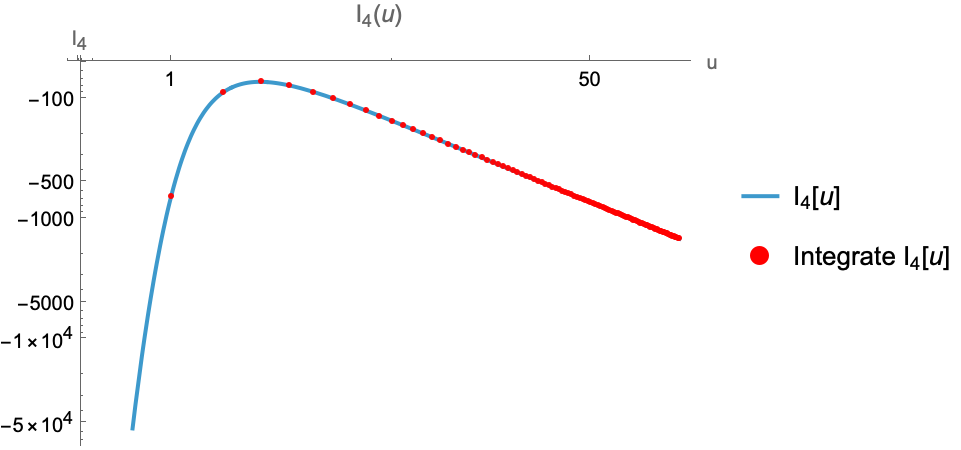

In [49]:
Show[
  Plot[
    N[I4[u]],
    {u, 0, 100},
    PlotLabel -> Subscript["I", 4][u],
    AxesLabel -> {"u", Subscript["I", 4]},
    PlotLegends -> {Subscript["I", 4][u]},
    ScalingFunctions -> {"SignedLog", "SignedLog"}
  ],
  ListPlot[
    points,
    (* Joined -> True, *)
    Mesh -> All,
    PlotStyle -> {Red, Dashed},
    PlotLegends -> {Subscript["Integrate I", 4][u]},
    ScalingFunctions -> {"SignedLog", "SignedLog"}
  ]
]

Legended[Legended[-Graphics-, Placed[LineLegend[{Directive[Opacity[1.], 
 
>        RGBColor[0.24, 0.6, 0.8], AbsoluteThickness[2]]}, {I [u]}, 
                                                             4
 
>      LegendMarkers -> None, LabelStyle -> {}, LegendLayout -> Column], After, Identity]
 
>     ], Placed[PointLegend[{Directive[PointSize[0.0128333], AbsoluteThickness[2], 
 
>       RGBColor[1, 0, 0], Dashing[{Small, Small}]]}, {Integrate I [u]}, 
                                                                  4
 
>     LegendMarkers -> {{False, Automatic}}, Joined -> {False}, LabelStyle -> {}, 
 
>     LegendLayout -> Column], After, Identity]]
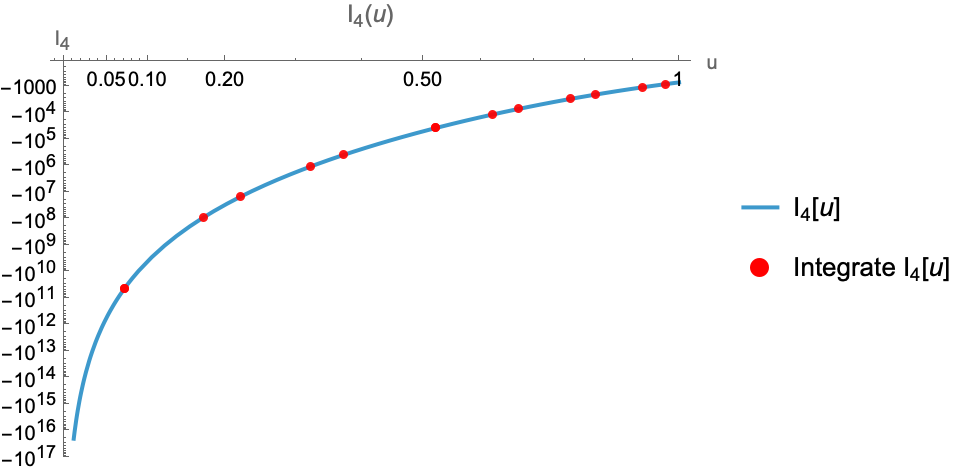

In [51]:
points01 = Table[{u, N[Integrate[integrand4[u, r], {r, r1[u], Infinity}]]}, {u, 0.02, 1, 0.05}];
Show[
  Plot[
    N[I4[u]],
    {u, 0, 1},
    PlotLabel -> Subscript["I", 4][u],
    AxesLabel -> {"u", Subscript["I", 4]},
    PlotLegends -> {Subscript["I", 4][u]},
    ScalingFunctions -> {"SignedLog", "SignedLog"}
  ],
  ListPlot[
    points01,
    (* Joined -> True, *)
    Mesh -> All,
    PlotStyle -> {Red, Dashed},
    PlotLegends -> {Subscript["Integrate I", 4][u]},
    ScalingFunctions -> {"SignedLog", "SignedLog"}
  ]
]

$$I_1 = \hat{r}_2 \left[ 120\hat{r}_2^{(1)}\omega^2\omega^{(1)} - 5\hat{r}_2^{(1)}\omega^{(3)} - 16\hat{r}_2\omega^5 - 10\hat{r}_2^{(2)}\omega^{(2)} + 60\hat{r}_2\omega(\omega^{(1)})^2
- 10\hat{r}_2^{(3)}\omega^{(1)} + 40\hat{r}_2^{(2)}\omega^3 - 5\hat{r}_2^{(4)}\omega - \hat{r}_2\omega^{(4)} + 40\hat{r}_2\omega^2\omega^{(2)} \right]$$

$$I_2 = 2\hat{r}_2 \left[ -40\hat{r}_2\omega^3\omega^{(1)} - 20\omega^4\hat{r}_2^{(1)} + 5\hat{r}_2\omega\omega^{(3)} + 10\hat{r}_2\omega^{(1)}\omega^{(2)} + 10\omega^2\hat{r}_2^{(3)} + 30\omega\omega^{(1)}\hat{r}_2^{(2)} + 20\omega\omega^{(2)}\hat{r}_2^{(1)} + 15\hat{r}_2^{(1)}(\omega^{(1)})^2 - \frac{1}{3}\hat{r}_2^{(5)} \right]$$

^
(b Sec[ϕ[t]] (2 Tan[ϕ[t]] ϕ'[t] (r)'[t] + 
 
        ^               2            2       2                        ^             2
>       r[t] ((Sec[ϕ[t]]  + Tan[ϕ[t]] ) ϕ'[t]  + Tan[ϕ[t]] ϕ''[t]) + (r)''[t])) / t
                                                                                   0
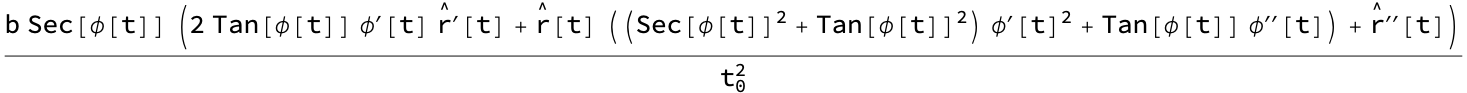

In [20]:
Simplify[D[Overscript[r, "^"][t]b/Cos[\[Phi][t]], {t, 2}]/Subscript[t, 0]^2]

^
(b Csc[ϕ[t]] (-2 Cot[ϕ[t]] ϕ'[t] (r)'[t] + 
 
        ^               2            2       2                        ^             2
>       r[t] ((Cot[ϕ[t]]  + Csc[ϕ[t]] ) ϕ'[t]  - Cot[ϕ[t]] ϕ''[t]) + (r)''[t])) / t
                                                                                   0
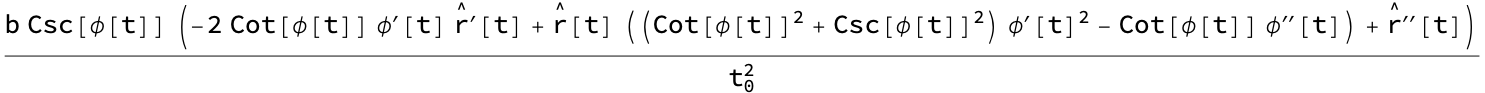

In [21]:
Simplify[D[Overscript[r, "^"][t]b/Sin[\[Phi][t]], {t, 2}]/Subscript[t, 0]^2]